In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import pickle
from scipy.stats import kstest
from collections import Counter
from scipy.stats import sem 
import pingouin as pg
import statsmodels.formula.api as smf
from statsmodels.stats.multitest import multipletests
import seaborn as sns

In [3]:
# INPUTS:

filepath = "F:/Two-Photon/Psilocybin Project/Evoked Cohort Mice/compiled_dicts"
z_thresh = 4

In [4]:
# Dictionary to map filenames to variable names
file_variable_mapping = {
    'saline_pre_dict.pkl': 'saline_pre',
    'saline_post_dict.pkl': 'saline_post',
    'psilo_pre_dict.pkl': 'psilo_pre',
    'psilo_post_dict.pkl': 'psilo_post'
}

# Initialize empty dictionaries
saline_pre = {}
saline_post = {}
psilo_pre = {}
psilo_post = {}

# Iterate through files in megadict folder
for filename in os.listdir(filepath):
    if filename in file_variable_mapping:
        file_path = os.path.join(filepath, filename)
        with open(file_path, 'rb') as file:
            # Load pkl file and assign to respective dictionary variable
            globals()[file_variable_mapping[filename]] = pickle.load(file)

In [ ]:
def get_sensitivity_all_cells(dict):
    
    sensitivity_all = []

    sub_dict_keys = dict.keys()

    for sub_dict in sub_dict_keys:
        for cell in dict[sub_dict]:

            if dict[sub_dict][cell]['active'] == True:
                tuning_array = np.array(dict[sub_dict][cell]['peak_tuning'])
                for i in range(len(tuning_array[0,:])):
                    if any(y > z_thresh for y in tuning_array[0:,i]):
                        sensitivity_all.append(float(i))
                        break
                    else:
                        continue

    return sensitivity_all

In [ ]:
def calculate_all_bandwidths(dict,No_sound_levels):

    sub_dict_keys = dict.keys()
    count = 0

    for sub_dict in sub_dict_keys:
        for cell in dict[sub_dict]:

            if dict[sub_dict][cell]['active'] == True:
                bandwidth_array = [0,0,0,0]
                count += 1

                for level in range(No_sound_levels):
                    level_array = dict[sub_dict][cell]['peak_tuning'][:,level]
                    if any(value >= z_thresh for value in level_array):
                        bandwidth_array[level] = count_above_half_max(level_array)
        
                dict[sub_dict][cell]['bandwidth'] = bandwidth_array
    print("The total number of cells in this cohort is", count)

In [18]:
def get_lowest_response_level(dict):

    sub_dict_keys = dict.keys()
    count = 0

    for sub_dict in sub_dict_keys:
        for cell in dict[sub_dict]:
                  
            if dict[sub_dict][cell]['active'] == True:
                dict[sub_dict][cell]['lowest_response_level'] = 'NaN'
                count += 1
                tuning_array = np.array(dict[sub_dict][cell]['peak_tuning'])
                for i in range(len(tuning_array[0,:])):
                    if any(y > z_thresh for y in tuning_array[0:,i]):
                        dict[sub_dict][cell]['lowest_response_level'] = float(i)
                        break
                    else:
                        continue

    print("The total number of cells in this cohort is", count)

get_lowest_response_level(saline_pre)
get_lowest_response_level(saline_post)
get_lowest_response_level(psilo_pre)
get_lowest_response_level(psilo_post)                        

The total number of cells in this cohort is 1307
The total number of cells in this cohort is 1222
The total number of cells in this cohort is 1194
The total number of cells in this cohort is 1214


In [22]:
print(saline_pre['saline_1_186'][1]['lowest_response_level'])

KeyError: 'lowest_response_level'

In [26]:
def dict_to_pd_lowest_response(dict,condition):
    rows = []

    for mouse_id, mouse_data in dict.items():

        base_mouse_id = mouse_id[-3:]

        for cell_id, cell_data in mouse_data.items():

            if cell_data['active'] == True and cell_data['lowest_response_level'] != 'NaN':
                unique_cell_id = f"{mouse_id}_{condition}_{cell_id}"
                row = {
                    'original_mouse_id': mouse_id,
                    'mouse_id': base_mouse_id,
                    'cell': cell_id,
                    'condition': condition,
                    'unique_cell_id': unique_cell_id,
                    'lowest_response_level': cell_data['lowest_response_level']
                }
                rows.append(row)
    df = pd.DataFrame(rows)

    return df

In [38]:
saline_pre_data = dict_to_pd_lowest_response(saline_pre,'pre')
saline_post_data = dict_to_pd_lowest_response(saline_post,'post')

psilo_pre_data = dict_to_pd_lowest_response(psilo_pre,'pre')
psilo_post_data = dict_to_pd_lowest_response(psilo_post,'post')

In [29]:
print(saline_pre['saline_1_186'][419]['peak_tuning'])

[[2.69810954e+00 3.99913329e-01 1.44702227e+00 1.70011845e+00]
 [3.25591354e+00 2.99128000e-02 1.67351881e+00 1.87052281e+00]
 [7.37903433e+00 2.70683454e+00 3.39510292e-01 1.15753253e+01]
 [7.93329031e-01 3.43677963e-01 7.10526755e+00 4.64975654e+01]
 [5.03402164e-01 4.35884615e-01 7.02006449e+00 3.54537511e+01]
 [6.10302872e-01 1.40725125e+00 9.26528171e-01 2.37629279e+01]
 [6.47444638e-01 5.79846728e-01 2.10596949e+00 1.82616784e+01]
 [5.47079951e+00 2.53154500e+00 7.81115822e+00 6.59243231e+00]
 [4.18524841e-01 7.89957610e-01 2.76551706e+00 8.56417204e+00]
 [8.46151834e-01 5.49457547e-01 4.26309748e-01 4.56901879e+00]
 [3.73839507e-01 9.31240356e-01 2.56989832e+00 4.56399183e+00]
 [6.00669070e+00 3.38283772e+00 1.39007826e+00 4.66782500e+00]]


In [28]:
saline_pre_data

,original_mouse_id,mouse_id,cell,condition,unique_cell_id,lowest_response_level
0,saline_1_186,186,4,pre,saline_1_186_pre_4,0.0
1,saline_1_186,186,14,pre,saline_1_186_pre_14,0.0
2,saline_1_186,186,15,pre,saline_1_186_pre_15,0.0
3,saline_1_186,186,18,pre,saline_1_186_pre_18,3.0
4,saline_1_186,186,28,pre,saline_1_186_pre_28,0.0
...,...,...,...,...,...,...
898,saline_1_474,474,1100,pre,saline_1_474_pre_1100,2.0
899,saline_1_474,474,1148,pre,saline_1_474_pre_1148,2.0
900,saline_1_474,474,1199,pre,saline_1_474_pre_1199,0.0
901,saline_1_474,474,1217,pre,saline_1_474_pre_1217,1.0


In [36]:
saline_data  = pd.concat([saline_pre_data,saline_post_data],ignore_index=True)

# Create separate dataframes for each bandwidth level
results = {}
print("saline Data Results")
    # Filter data for this bandwidth level
level_data = saline_data[['original_mouse_id', 'unique_cell_id', 'condition', 'lowest_response_level']]
    
    # Fit model for this bandwidth level
model = smf.mixedlm(
    "lowest_response_level ~ condition", 
    saline_data, 
    groups=saline_data["original_mouse_id"]
    )
    
results = model.fit()
print(results.summary())

saline Data Results
               Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: lowest_response_level
No. Observations: 1685    Method:             REML                 
No. Groups:       16      Scale:              1.1114               
Min. group size:  30      Log-Likelihood:     -2500.6169           
Max. group size:  179     Converged:          Yes                  
Mean group size:  105.3                                            
--------------------------------------------------------------------
                     Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
--------------------------------------------------------------------
Intercept             1.236     0.131   9.462  0.000   0.980   1.492
condition[T.pre]     -0.056     0.184  -0.308  0.758  -0.416   0.303
Group Var             0.122     0.048                               



C:\Users\Conor\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\iolib\summary2.py:579: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  dat = dat.applymap(lambda x: _formatter(x, float_format))


In [37]:
import pandas as pd
import statsmodels.formula.api as smf

# Combine pre- and post- saline data
saline_data = pd.concat([saline_pre_data, saline_post_data], ignore_index=True)

# Fit a linear mixed-effects model
print("Saline Data Results")

model = smf.mixedlm(
    "lowest_response_level ~ condition", 
    saline_data, 
    groups=saline_data["original_mouse_id"]
)

results = model.fit()
print(results.summary())

Saline Data Results
               Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: lowest_response_level
No. Observations: 1685    Method:             REML                 
No. Groups:       16      Scale:              1.1114               
Min. group size:  30      Log-Likelihood:     -2500.6169           
Max. group size:  179     Converged:          Yes                  
Mean group size:  105.3                                            
--------------------------------------------------------------------
                     Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
--------------------------------------------------------------------
Intercept             1.236     0.131   9.462  0.000   0.980   1.492
condition[T.pre]     -0.056     0.184  -0.308  0.758  -0.416   0.303
Group Var             0.122     0.048                               



C:\Users\Conor\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\iolib\summary2.py:579: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  dat = dat.applymap(lambda x: _formatter(x, float_format))


In [40]:
import pandas as pd
import statsmodels.formula.api as smf

# Combine pre- and post- saline data
psilo_data = pd.concat([psilo_pre_data, psilo_post_data], ignore_index=True)

# Fit a linear mixed-effects model
print("Saline Data Results")

model = smf.mixedlm(
    "lowest_response_level ~ condition", 
    psilo_data, 
    groups=psilo_data["original_mouse_id"]
)

results = model.fit()
print(results.summary())

Saline Data Results
               Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: lowest_response_level
No. Observations: 1466    Method:             REML                 
No. Groups:       16      Scale:              1.1076               
Min. group size:  27      Log-Likelihood:     -2173.7476           
Max. group size:  150     Converged:          Yes                  
Mean group size:  91.6                                             
---------------------------------------------------------------------
                   Coef.   Std.Err.     z     P>|z|   [0.025   0.975]
---------------------------------------------------------------------
Intercept          1.024      0.124   8.260   0.000    0.781    1.266
condition[T.pre]   0.040      0.175   0.228   0.820   -0.302    0.382
Group Var          0.106      0.043                                  



C:\Users\Conor\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\iolib\summary2.py:579: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  dat = dat.applymap(lambda x: _formatter(x, float_format))


In [41]:
#Correctly define the groups, i.e. saline post and psilo post

pre_saline = saline_data[saline_data['condition'] == 'pre']
pre_saline['treatment'] = 'saline'
pre_psilo = psilo_data[psilo_data['condition'] == 'pre']
pre_psilo['treatment'] = 'psilocybin'

pre_all = pd.concat([pre_saline,pre_psilo],ignore_index=True)

C:\Users\Conor\AppData\Local\Temp\ipykernel_19008\1047157310.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pre_saline['treatment'] = 'saline'
C:\Users\Conor\AppData\Local\Temp\ipykernel_19008\1047157310.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pre_psilo['treatment'] = 'psilocybin'


In [ ]:
#Correctly define the groups, i.e. saline post and psilo post

post_saline = saline_data[saline_data['condition'] == 'post']
post_saline['treatment'] = 'saline'
post_psilo = psilo_data[psilo_data['condition'] == 'post']
post_psilo['treatment'] = 'psilocybin'

post_all = pd.concat([post_saline,post_psilo],ignore_index=True)

C:\Users\Conor\AppData\Local\Temp\ipykernel_19008\476657197.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  post_saline['treatment'] = 'saline'
C:\Users\Conor\AppData\Local\Temp\ipykernel_19008\476657197.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  post_psilo['treatment'] = 'psilocybin'


In [ ]:
post_all

In [78]:
# Fit a linear mixed-effects model
print("Saline Data Results")

model = smf.mixedlm(
    "lowest_response_level ~ treatment", 
    pre_all, 
    groups=pre_all["original_mouse_id"]
)

results = model.fit()
print(results.summary())

Saline Data Results
               Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: lowest_response_level
No. Observations: 1644    Method:             REML                 
No. Groups:       16      Scale:              1.0979               
Min. group size:  27      Log-Likelihood:     -2431.3234           
Max. group size:  179     Converged:          Yes                  
Mean group size:  102.8                                            
--------------------------------------------------------------------
                       Coef.  Std.Err.    z    P>|z|  [0.025  0.975]
--------------------------------------------------------------------
Intercept              1.060     0.142  7.475  0.000   0.782   1.338
treatment[T.saline]    0.118     0.199  0.594  0.553  -0.272   0.509
Group Var              0.146     0.057                              



C:\Users\Conor\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\iolib\summary2.py:579: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  dat = dat.applymap(lambda x: _formatter(x, float_format))


In [79]:
# Fit a linear mixed-effects model
print("Saline Data Results")

model = smf.mixedlm(
    "lowest_response_level ~ treatment", 
    post_all, 
    groups=post_all["original_mouse_id"]
)

results = model.fit()
print(results.summary())

Saline Data Results
               Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: lowest_response_level
No. Observations: 1507    Method:             REML                 
No. Groups:       16      Scale:              1.1225               
Min. group size:  28      Log-Likelihood:     -2242.5067           
Max. group size:  179     Converged:          Yes                  
Mean group size:  94.2                                             
--------------------------------------------------------------------
                       Coef.  Std.Err.    z    P>|z|  [0.025  0.975]
--------------------------------------------------------------------
Intercept              1.026     0.111  9.276  0.000   0.809   1.243
treatment[T.saline]    0.211     0.156  1.360  0.174  -0.093   0.516
Group Var              0.081     0.034                              



C:\Users\Conor\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\iolib\summary2.py:579: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  dat = dat.applymap(lambda x: _formatter(x, float_format))


In [64]:
post_all = post_all.drop(['response_bin'], axis=1)

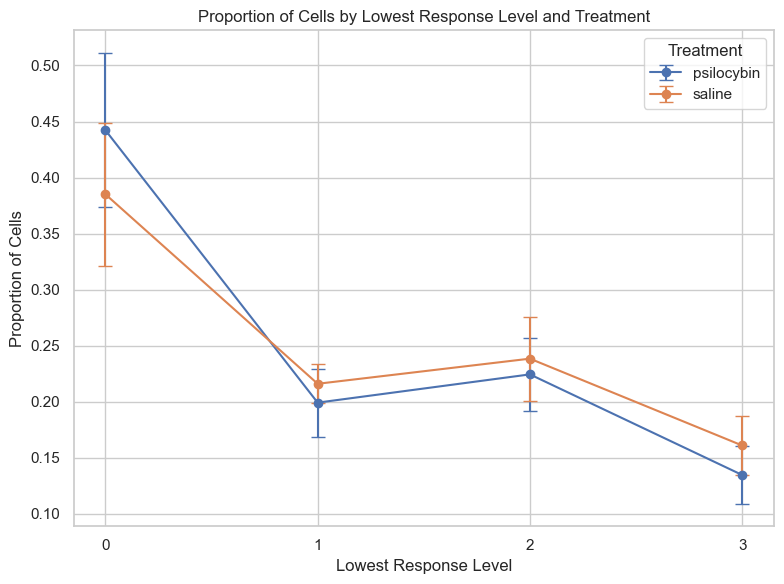

In [69]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import sem
df = pre_all
# Count how many cells per mouse, treatment, lowest_response_level
counts = df.groupby(['original_mouse_id', 'treatment', 'lowest_response_level']).size().rename('count').reset_index()

# Merge total cells to compute proportion
total_cells = df.groupby(['original_mouse_id', 'treatment']).size().rename('total_cells')
counts = counts.merge(total_cells.reset_index(), on=['original_mouse_id', 'treatment'])
counts['proportion'] = counts['count'] / counts['total_cells']

# Aggregate across mice: mean and SEM proportion per treatment and lowest_response_level
summary = counts.groupby(['treatment', 'lowest_response_level'])['proportion'].agg(['mean', sem]).reset_index()

# Plot
plt.figure(figsize=(8,6))

for treatment, group in summary.groupby('treatment'):
    plt.errorbar(
        group['lowest_response_level'],
        group['mean'],
        yerr=group['sem'],
        label=treatment,
        marker='o',
        capsize=5,
        linestyle='-'
    )

plt.xlabel('Lowest Response Level')
plt.ylabel('Proportion of Cells')
plt.title('Proportion of Cells by Lowest Response Level and Treatment')
plt.xticks([0,1,2,3])
plt.legend(title='Treatment')
plt.tight_layout()
plt.show()

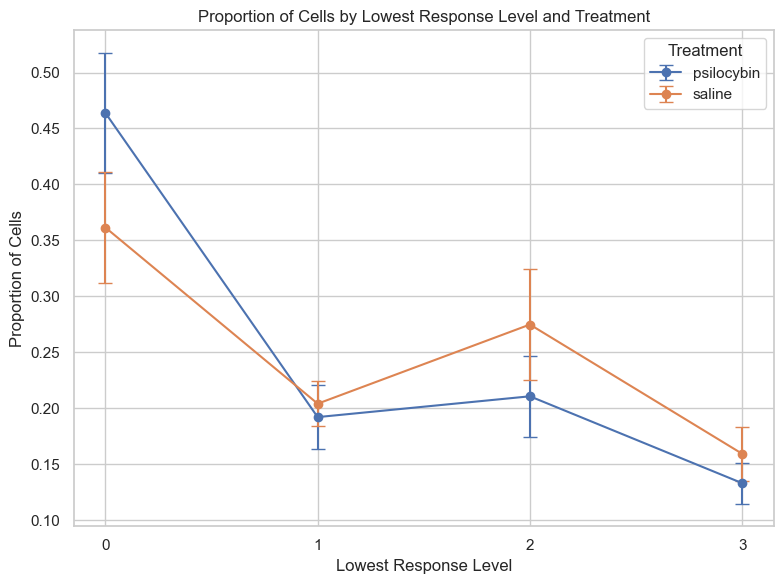

In [70]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import sem
df = post_all
# Count how many cells per mouse, treatment, lowest_response_level
counts = df.groupby(['original_mouse_id', 'treatment', 'lowest_response_level']).size().rename('count').reset_index()

# Merge total cells to compute proportion
total_cells = df.groupby(['original_mouse_id', 'treatment']).size().rename('total_cells')
counts = counts.merge(total_cells.reset_index(), on=['original_mouse_id', 'treatment'])
counts['proportion'] = counts['count'] / counts['total_cells']

# Aggregate across mice: mean and SEM proportion per treatment and lowest_response_level
summary = counts.groupby(['treatment', 'lowest_response_level'])['proportion'].agg(['mean', sem]).reset_index()

# Plot
plt.figure(figsize=(8,6))

for treatment, group in summary.groupby('treatment'):
    plt.errorbar(
        group['lowest_response_level'],
        group['mean'],
        yerr=group['sem'],
        label=treatment,
        marker='o',
        capsize=5,
        linestyle='-'
    )

plt.xlabel('Lowest Response Level')
plt.ylabel('Proportion of Cells')
plt.title('Proportion of Cells by Lowest Response Level and Treatment')
plt.xticks([0,1,2,3])
plt.legend(title='Treatment')
plt.tight_layout()
plt.show()

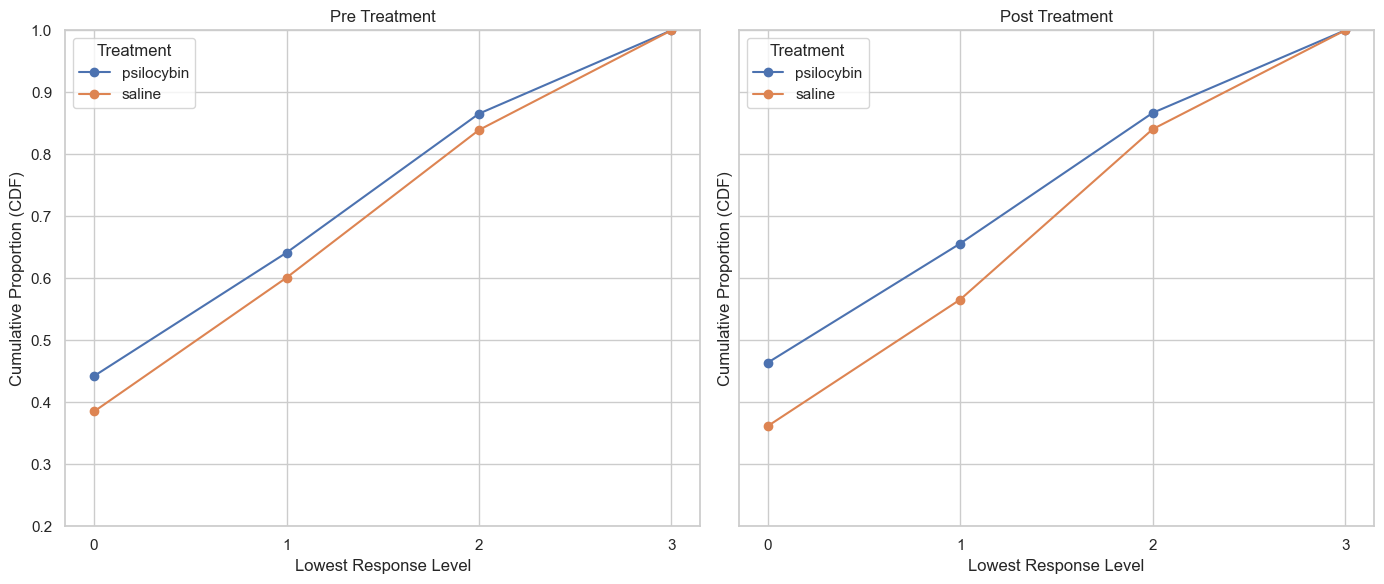

In [76]:
import matplotlib.pyplot as plt

def plot_cdf_raw_lines(ax, counts_df, title):
    levels = sorted(counts_df['lowest_response_level'].unique())

    total_cells = counts_df.groupby(['original_mouse_id', 'treatment']).size().rename('total_cells').reset_index()
    counts = counts_df.groupby(['original_mouse_id', 'treatment', 'lowest_response_level']).size().rename('count').reset_index()
    counts = counts.merge(total_cells, on=['original_mouse_id', 'treatment'])
    counts['proportion'] = counts['count'] / counts['total_cells']

    counts = counts.sort_values(['original_mouse_id', 'treatment', 'lowest_response_level'])
    counts['cdf'] = counts.groupby(['original_mouse_id', 'treatment'])['proportion'].cumsum()

    summary = counts.groupby(['treatment', 'lowest_response_level'])['cdf'].mean().reset_index()

    for treatment, group in summary.groupby('treatment'):
        ax.plot(group['lowest_response_level'], group['cdf'], label=treatment, marker='o')

    ax.set_xlabel('Lowest Response Level')
    ax.set_ylabel('Cumulative Proportion (CDF)')
    ax.set_title(title)
    ax.set_xticks(levels)
    ax.set_ylim(0.2, 1)
    ax.legend(title='Treatment')

fig, axs = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

plot_cdf_raw_lines(axs[0], pre_all, 'Pre Treatment')
plot_cdf_raw_lines(axs[1], post_all, 'Post Treatment')

plt.tight_layout()
plt.show()